# Implementation of Liquid Neural Networks

The focus of this document is the implementation of the LTC networks, in form of LTC, CFC and NCP. This document does not mention what they are, but rather how to use them in different scenarios.




The implementation discussed in this document is through `ncps` package. This package provides 2 models, LTC (Liquid Time-Constant) and CFC (Closed-Form Continuous-Time) models. Both these models are available as `tf.keras.layers.Layer` or `torch.nn.Module` RNN layers.

The Tensorflow bindings are available via the `ncps.tf` module. \
The Pytorch bindings are available via the `ncps.torch` module.

In [5]:
# installing the ncps package
! pip install ncps seaborn

## Tensorflow usage

I will only focus on the tensorflow implementation of the Neural Nets.

In [48]:
# how to define an LTC or CfC cell
from ncps.tf import LTC, CfC

units = 28
rnn1 = LTC(units)                 # fully-connected LTC
rnn2 = CfC(units)                 # fully-connected CfC

In [49]:
# we can also define custom wirings
# this is essential for plotting the rnn cell
from ncps import wirings

ncp_wiring = wirings.AutoNCP(28, 4)       # 28 total neurons (excluding sensory input neurons), 4 output neurons
fc_wiring = wirings.FullyConnected(8,1)   # 8 total neurons, 1 motor output neuron (7 inter neurons)
# fc_wiring = wirings.FullyConnected(8)     # 8 total neurons, all of which are motor neurons

rnn3 = LTC(ncp_wiring)            # NCP wired LTC
rnn4 = CfC(ncp_wiring)            # NCP wired CfC
rnn5 = LTC(fc_wiring)             # Fully connected LTC, with custom wiring
rnn6 = LTC(ncp_wiring, return_sequences = True)            # NCP wired LTC

You can only plot the above rnn cells:
- if you  use the wirings class to define wiring.
- and if you have built a model.

In [53]:
# how to add the above rnn cell in a neural network?
from tensorflow import keras


model = keras.models.Sequential([

    # this layer decides the input sensory neurons
    keras.layers.InputLayer(input_shape=(None, 2)),

    # here we could add layers before and after the LTC rnn cell

    # rnn1,
    LTC(ncp_wiring, return_sequences=True),
])

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss='mean_squared_error'
)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ltc_31 (LTC)                (None, None, 4)           3456      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can create an RNN cell before defining the model, or while defining the model.
- `return_Sequences = True` argument in the LTC class, adds one more dimension to the output.

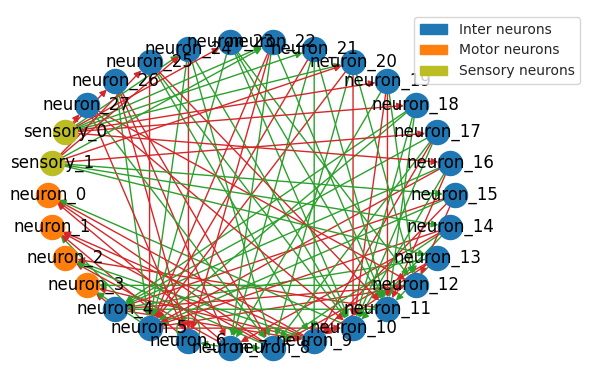

In [46]:
# plotting the wirings of the rnn cell of the model
import seaborn as sns
import matplotlib.pyplot as plt


# you can only plot the wiring
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_wiring.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### How to combine NCP cell with arbitraty `tf.keras.layers`?

Here is an example to build an image sequence classifier. This combines an NCP cell with Conv2D layers etc.

In [58]:
from ncps.wirings import AutoNCP
from ncps.tf import LTC
from tensorflow import keras

# image resolution
height, width, channels = (78, 200, 3)

ncp_wiring = AutoNCP(32, output_size=8)
ncp = LTC(ncp_wiring, return_sequences=True)

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, height, width, channels)),
        keras.layers.TimeDistributed(
            keras.layers.Conv2D(32, (5, 5), activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv2D(64, (5, 5), activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D()),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.TimeDistributed(keras.layers.Dense(32, activation="relu")),
        ncp,
        keras.layers.TimeDistributed(keras.layers.Activation("softmax")),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss='sparse_categorical_crossentropy',
)

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDi  (None, None, 74, 196, 3   2432      
 stributed)                  2)                                  
                                                                 
 time_distributed_8 (TimeDi  (None, None, 37, 98, 32   0         
 stributed)                  )                                   
                                                                 
 time_distributed_9 (TimeDi  (None, None, 33, 94, 64   51264     
 stributed)                  )                                   
                                                                 
 time_distributed_10 (TimeD  (None, None, 16, 47, 64   0         
 istributed)                 )                                   
                                                                 
 time_distributed_11 (TimeD  (None, None, 48128)     